In [1]:
import os
import pandas.io.sql as psql
import sqlalchemy

root = os.path.join(os.pardir, os.pardir)

env = {}
with open(os.path.join(root, ".env"), "r") as envfile:
    while line := envfile.readline():
        line = line.split("#")[0]         # Remove comments.
        line = line.strip()               # Strip extra space.
        name, variable = line.split("=")  # NAME=VARIABLE
        env[name] = variable

conn_string = "postgresql+psycopg2://" \
              "{POSTGRES_USER}:{POSTGRES_PASSWORD}@" \
              "localhost:5432/{POSTGRES_DB}"
conn_string = conn_string.format(**env)

engine = sqlalchemy.create_engine(conn_string)

query = "SELECT t.id, t.processed, hr.rating " \
        "FROM classifier_app_humanrating hr " \
        "LEFT JOIN classifier_app_text t " \
            "ON t.id = hr.text_id"

df = psql.read_sql(query, engine)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    df["processed"].astype("U"),
    df["rating"],
    test_size=0.2,
    shuffle=True
)

pipeline = Pipeline([
    ("vect", TfidfVectorizer(max_df=0.6, min_df=3, ngram_range=(1, 2))),
    ("chi2", SelectKBest(chi2, k=10000)),
    ("mnb", MultinomialNB(alpha=1e-06))
])

              precision    recall  f1-score   support

       False       0.87      0.85      0.86     29934
        True       0.85      0.87      0.86     28933

    accuracy                           0.86     58867
   macro avg       0.86      0.86      0.86     58867
weighted avg       0.86      0.86      0.86     58867



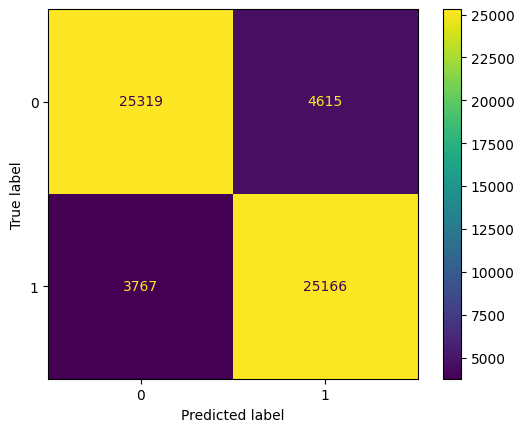

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(cm).plot()

In [4]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import warnings

warnings.filterwarnings("ignore")

parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "chi2__k": (1, 10, 100, 1000, 10000),
    "mnb__alpha": np.logspace(-6, 6, 13)
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=8,
    verbose=0
)

random_search.fit(X_train, y_train)

print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
chi2__k: 10000
mnb__alpha: 1e-06
vect__max_df: 0.6
vect__min_df: 3
vect__ngram_range: (1, 2)


In [5]:
import math
import pandas
import plotly.express as px

def shorten_param(param_name):
    """Remove components' prefixes in param_name."""
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = pandas.DataFrame(random_search.cv_results_)
cv_results = cv_results.rename(shorten_param, axis=1)
param_names = [shorten_param(name) for name in parameter_grid.keys()]
labels = {
    "mean_score_time": "CV Score time (s)",
    "mean_test_score": "CV score (accuracy)",
    "alpha": "log(alpha)",
    "k": "log(k)"
}

column_results = param_names + ["mean_test_score", "mean_score_time"]

transform_funcs = dict.fromkeys(column_results, lambda x: x)
# Using a logarithmic scale for alpha
transform_funcs["alpha"] = math.log10
# Using a logarithmic scale for k
transform_funcs["k"] = math.log10
# Unigrams are mapped to index 1 and bigrams to index 2
transform_funcs["ngram_range"] = lambda x: x[1]

fig = px.parallel_coordinates(
    cv_results[column_results].apply(transform_funcs),
    color="mean_test_score",
    color_continuous_scale=px.colors.diverging.Temps_r,
    labels=labels,
    width=1000
)
fig.show()